***IMPORTING LIBRARIES***

In [ ]:
# Importing Data Analysis Libraries
import pandas as pd
import numpy as np

# Normalize Dataset
from sklearn.preprocessing import MinMaxScaler

# Splitting Data into train set and Test set
from sklearn.model_selection import train_test_split

# Importing Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("darkgrid")

# Python drawing
from IPython.core.pylabtools import figsize

# Importing Tensorflow and Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger # Generating Model logs
from tensorflow.keras.utils import plot_model


# Model Evaluation
from sklearn.metrics import r2_score

# Convert Object to Datetime and display in matplotlib without casting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# TF Global random seed set for reproducibility
tf.random.set_seed(29)

***DEFINING GLOBAL VARIABLES AND FUNCTIONS FOR CODE REUSE***

In [ ]:
# Creating directory for saving log and model.
!mkdir -p saved_data

# CSVLogger variable for generating model logs
csv_logger = CSVLogger('saved_data/training.log', ',', append=True)

# Future close variable
next_close = 'FUTURE_CLOSE'

# Hyperparameter for data transformation
TIME_STEPS = 10

# FUNCTION TO PLOT A FIGURE OBJECT
legend_loc= 'upper left'
def plot_figure(xlabel, ylabel, title, legend_loc):
    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    plt.title(title)
    plt.legend(loc=legend_loc)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return plt

***IMPORTING DATA***

In [ ]:
# Fetching the csv dataset from GitHub repository
crypto_dataframe = pd.read_csv("https://raw.githubusercontent.com/247pankaj/crypto-dataset/main/Bitcoin_price.csv")

In [ ]:
# Printing the last 5 records in dataset
crypto_dataframe.head()

,Date,Open,High,Low,Close,Volume,MarketCap
0,29-Apr-13,134.44,147.49,134.00,144.54,0.0,1.603769e+09
1,30-Apr-13,144.00,146.93,134.05,139.00,0.0,1.542813e+09
2,01-May-13,139.00,139.89,107.72,116.99,0.0,1.298955e+09
3,02-May-13,116.38,125.60,92.28,105.21,0.0,1.168517e+09
4,03-May-13,106.25,108.13,79.10,97.75,0.0,1.085995e+09


In [ ]:
# Feature DataTypes
crypto_dataframe.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
MarketCap    float64
dtype: object

***DATA PREPROCESSING***

In [ ]:
# Converting Date Object into Datetime
crypto_dataframe['Date'] = crypto_dataframe['Date'].astype('datetime64[ns]')

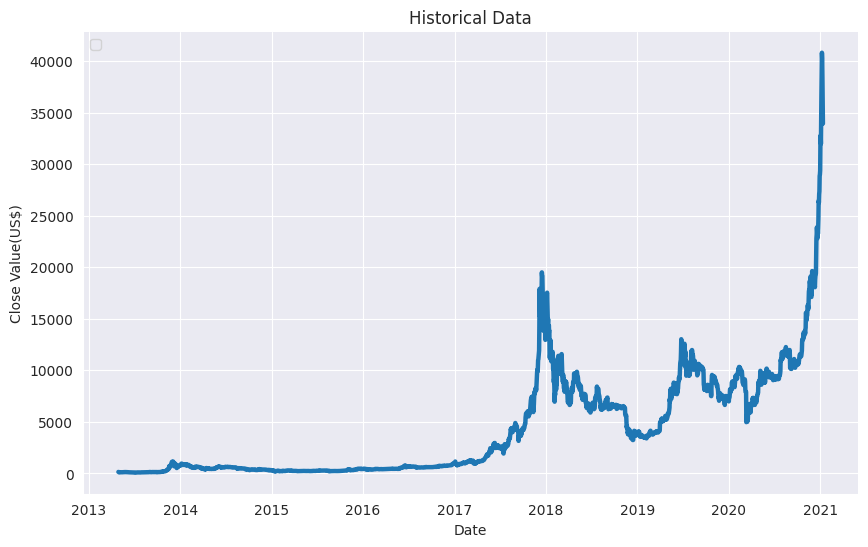

In [ ]:
# Plotting the dataset
plot_fig = plot_figure("Date", "Close Value(US$)", "Historical Data", legend_loc) #plot_figure(xlabel, ylabel, title, legend_loc)
sns.set_context("paper", font_scale=2.1, rc={"lines.linewidth": 3.2})
sns.lineplot(data=crypto_dataframe, x="Date", y="Close")
horizontalalignment='center'
sns.despine()

In [ ]:
crypto_dataframe[next_close] = crypto_dataframe['Close'].shift(-1,fill_value=0)

In [ ]:
crypto_dataframe.drop(crypto_dataframe.tail(1).index,inplace=True)

In [ ]:
crypto_dataframe = crypto_dataframe.drop(columns=['Close'])

In [ ]:
crypto_dataframe = crypto_dataframe.set_index('Date')

In [ ]:
crypto_dataframe.head()

,Open,High,Low,Volume,MarketCap,FUTURE_CLOSE
Date,,,,,,
2013-04-29,134.44,147.49,134.00,0.0,1.603769e+09,139.00
2013-04-30,144.00,146.93,134.05,0.0,1.542813e+09,116.99
2013-05-01,139.00,139.89,107.72,0.0,1.298955e+09,105.21
2013-05-02,116.38,125.60,92.28,0.0,1.168517e+09,97.75
2013-05-03,106.25,108.13,79.10,0.0,1.085995e+09,112.50


In [ ]:
# Train-Test Split(80%-20%)
train_size = int(len(crypto_dataframe)*0.8)
train_dataset, test_dataset = crypto_dataframe.iloc[:train_size],crypto_dataframe.iloc[train_size:]

No handles with labels found to put in legend.


Dimension of train data:  (2252, 6)
Dimension of test data:  (563, 6)


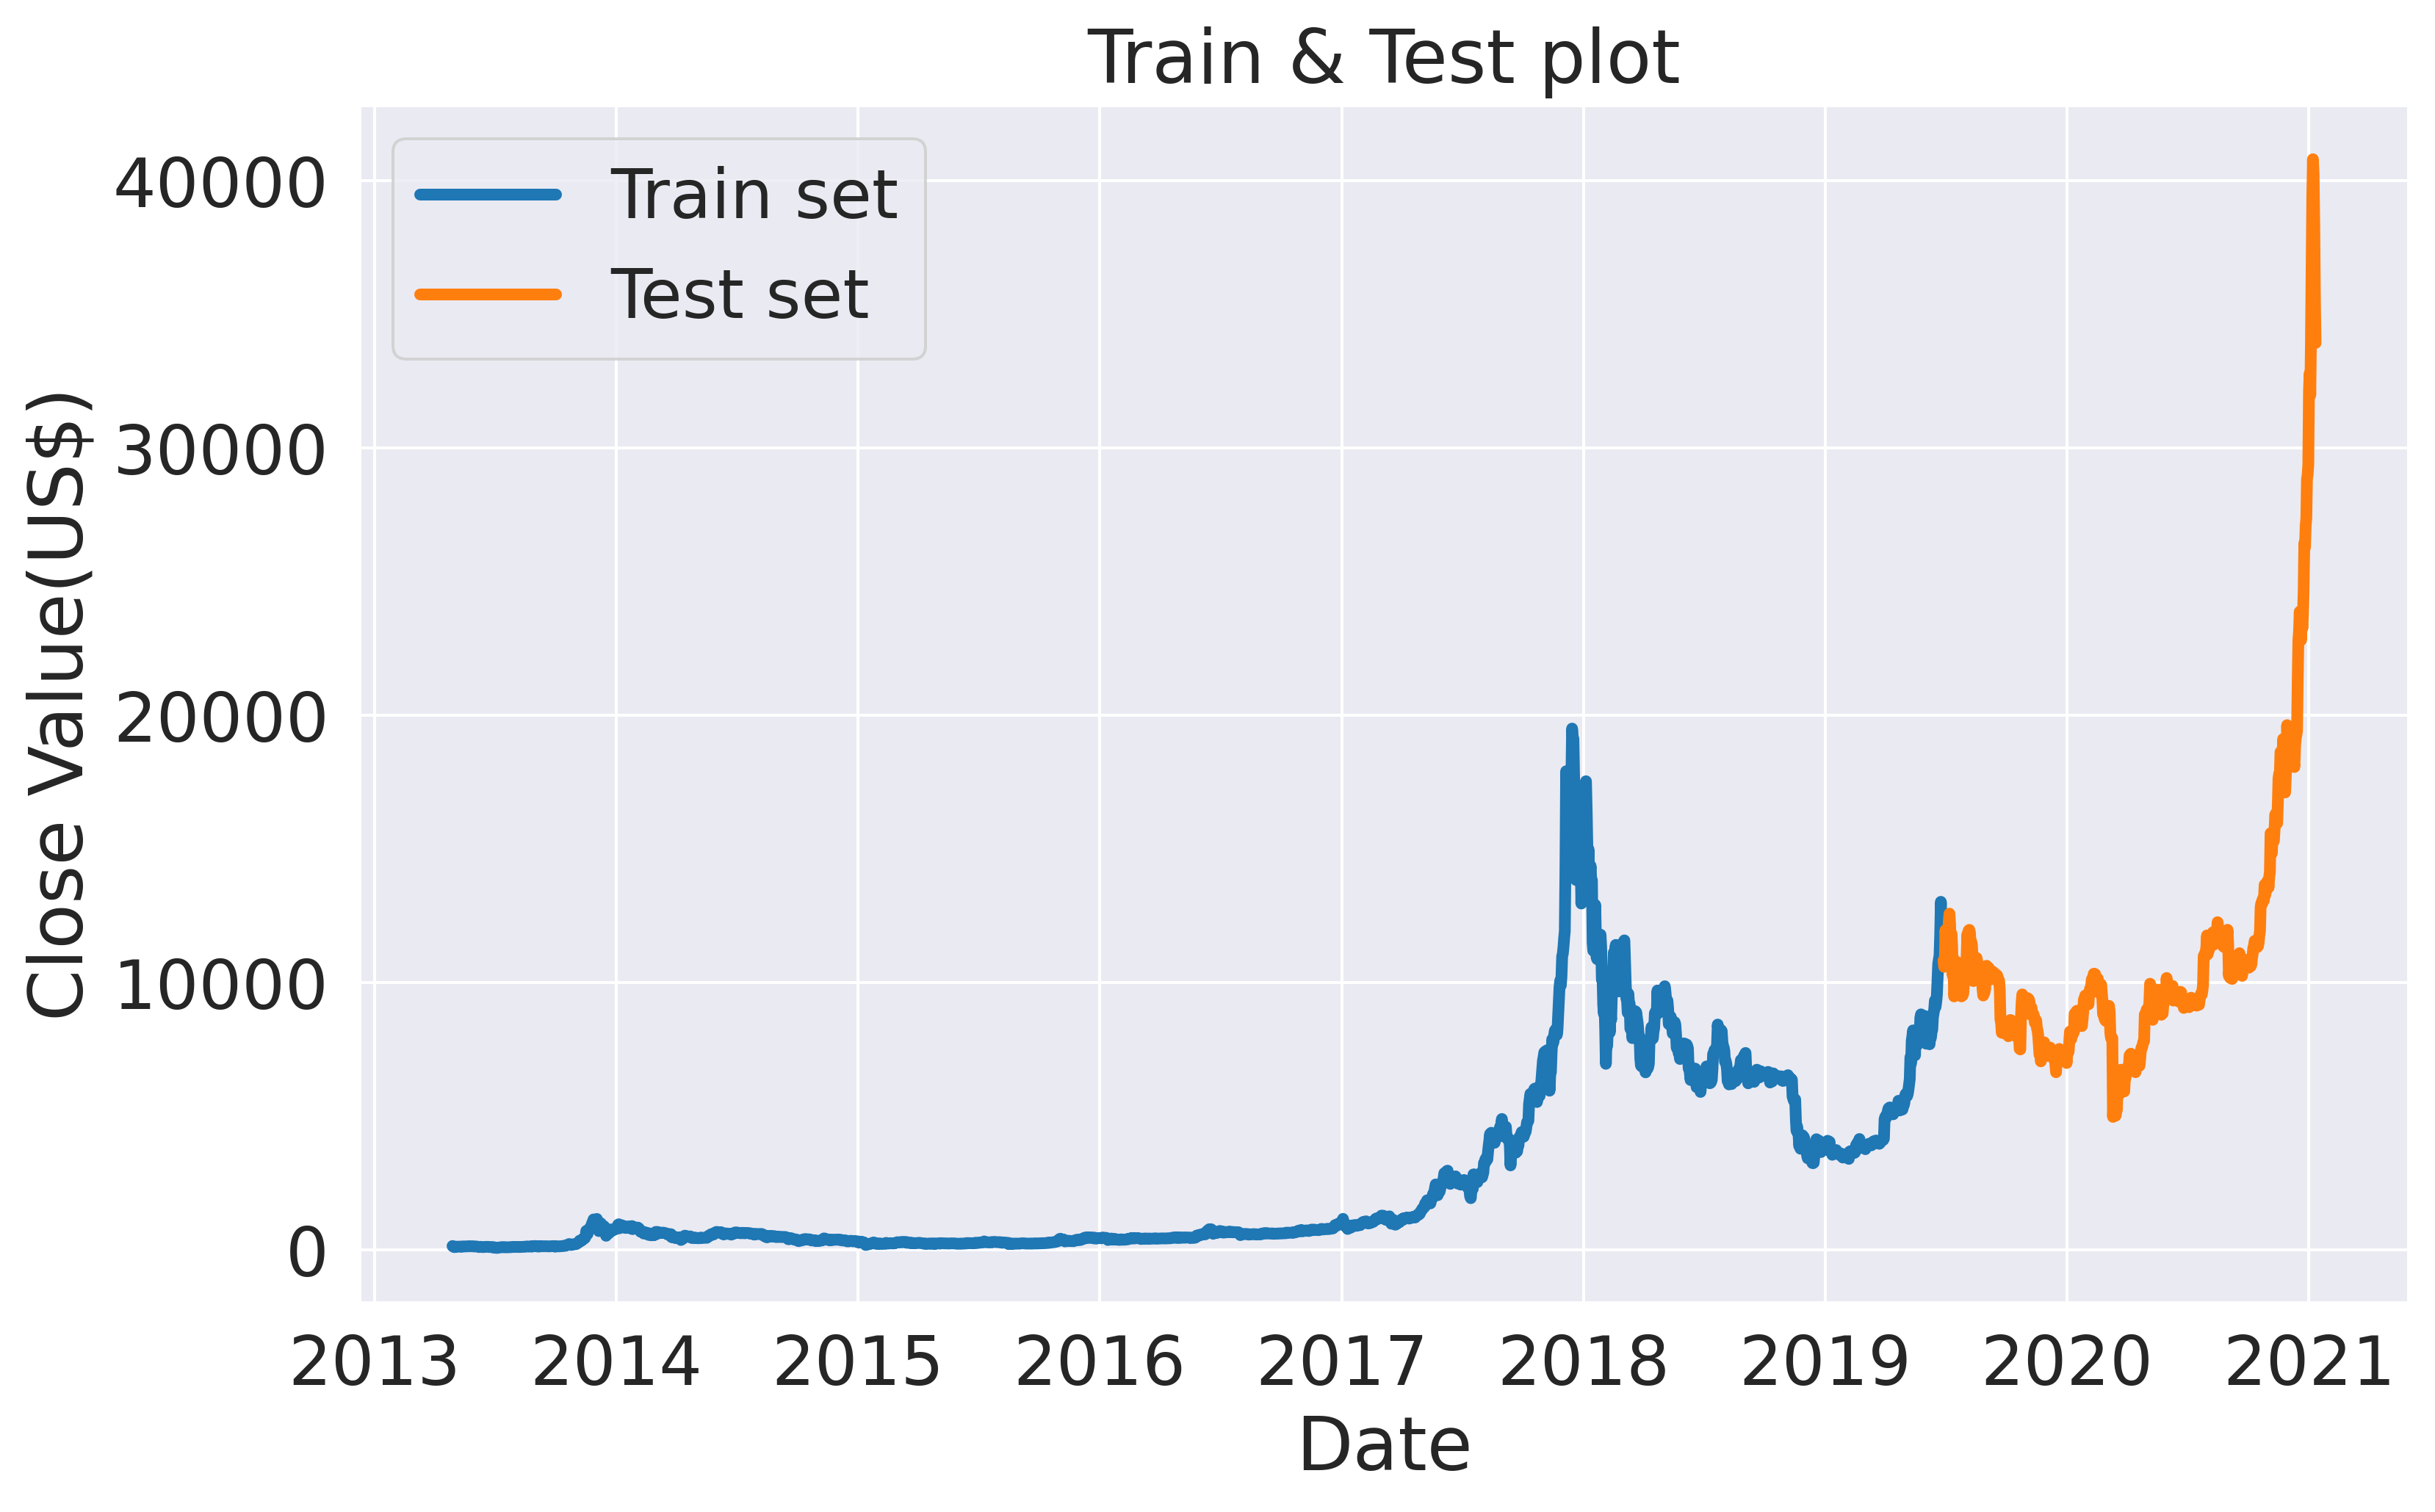

In [ ]:
plt_fig = plot_figure("Date", "Close Value(US$)", "Train & Test plot", legend_loc) #plot_figure(xlabel, ylabel, title, legend_loc)

plt_fig.plot(train_dataset.FUTURE_CLOSE)
plt_fig.plot(test_dataset.FUTURE_CLOSE)
plt_fig.legend(['Train set', 'Test set'], loc='upper left')

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [ ]:
# Split train data to X and y
X_train = train_dataset.drop(next_close, axis = 1)
y_train = train_dataset.loc[:,[next_close]]

# Split test data to X and y
X_test = test_dataset.drop(next_close, axis = 1)
y_test = test_dataset.loc[:,[next_close]]

In [ ]:
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply scaler => training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply scaler => test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

***DATA TRANSFORMATION***

In [ ]:
def transform_dataset (X_array, y_array, time_steps = 1):
    X_transform, y_transform = [], []
    for i in range(len(X_array) - time_steps):
        output = X_array[i:i+time_steps, :]
        X_transform.append(output)
        y_transform.append(y_array[i+time_steps])

    return np.array(X_transform), np.array(y_transform)


X_test, y_test = transform_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = transform_dataset(train_x_norm, train_y_norm, TIME_STEPS)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)
print('X_train: ', X_train)

X_train.shape:  (2242, 10, 5)
y_train.shape:  (2242, 1)
X_test.shape:  (553, 10, 5)
y_test.shape:  (553, 1)
X_train:  [[[-0.99320462 -0.99271226 -0.99275778 -1.         -0.9949399 ]
  [-0.99221942 -0.99276822 -0.99275249 -1.         -0.9953136 ]
  [-0.99273469 -0.99347171 -0.99553747 -1.         -0.99680865]
  ...
  [-0.995107   -0.99499361 -0.99565171 -1.         -0.99711477]
  [-0.99549139 -0.99611481 -0.99659731 -1.         -0.99716645]
  [-0.99576448 -0.99588097 -0.99533862 -1.         -0.99702265]]

 [[-0.99221942 -0.99276822 -0.99275249 -1.         -0.9953136 ]
  [-0.99273469 -0.99347171 -0.99553747 -1.         -0.99680865]
  [-0.99506577 -0.99489968 -0.9971706  -1.         -0.99760834]
  ...
  [-0.99549139 -0.99611481 -0.99659731 -1.         -0.99716645]
  [-0.99576448 -0.99588097 -0.99533862 -1.         -0.99702265]
  [-0.99539349 -0.99611281 -0.99537458 -1.         -0.99708098]]

 [[-0.99273469 -0.99347171 -0.99553747 -1.         -0.99680865]
  [-0.99506577 -0.99489968 -0.9971

***DATA MODELING***

*   Model Creation
*   Model Training
*   Hyperparameter Tune
*   Sequential and parallel architecture implementation

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 256)      103680      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 10, 128)      27264       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          296448      bidirectional[0][0]              
______________________________________________________________________________________________

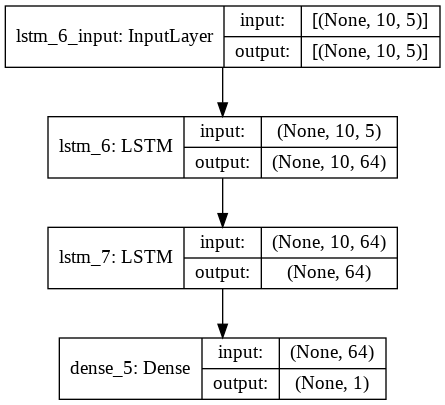

In [ ]:
# BiRNN model using Functional API of Keras
def create_model_birnn_func(units, mt):
    input1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
    hidden1 = Bidirectional(mt(units = 2*units, return_sequences=True))(input1)
    hidden2 = Bidirectional(mt(units = 2*units))(hidden1)

    hidden3 = Bidirectional(mt(units = units, return_sequences=True))(input1)
    hidden4 = Bidirectional(mt(units = units))(hidden3)

    hidden5 = keras.layers.concatenate([hidden2, hidden4])
    output = Dense(1)(hidden5)

    model_func = Model(inputs=input1, outputs=output)

    model_func.compile(loss='mse', optimizer='adam')
    return model_func


# Create Bi Sequential model
def create_model_birnn(units, mt):
    model = Sequential()
    model.add(Bidirectional(mt(units = units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))

    model.add(Bidirectional(mt(units = units)))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU Sequential model
def create_model_sequential(units, mt):
    model = Sequential()

    model.add(mt (units = units, return_sequences = True,
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    #model.add(Dropout(0.2))

    model.add(mt (units = units))
    #model.add(Dropout(0.2))
    model.add(Dense(units = 1))

    model.compile(loss='mse', optimizer='adam')
    return model

# Functional API BiRNN
model_bigru_func = create_model_birnn_func(64, GRU)
model_bilstm_func = create_model_birnn_func(64, LSTM)


# BiRNN Sequential GRU and LSTM
model_bigru = create_model_birnn(64, GRU)
model_bilstm = create_model_birnn(64, LSTM)


# GRU and LSTM Sequential
model_gru = create_model_sequential(64, GRU)
model_lstm = create_model_sequential(64, LSTM)

# Model summary and plot
model_bigru_func.summary()
plot_model(model_bigru_func, to_file='saved_data/model_bigru_func.png', show_shapes=True, show_layer_names=True)

model_bilstm_func.summary()
plot_model(model_bilstm_func, to_file='saved_data/model_bilstm_func.png', show_shapes=True, show_layer_names=True)

model_bigru.summary()
plot_model(model_bigru, to_file='saved_data/model_bigru.png', show_shapes=True, show_layer_names=True)

model_bilstm.summary()
plot_model(model_bilstm, to_file='saved_data/model_bilstm.png', show_shapes=True, show_layer_names=True)

model_gru.summary()
plot_model(model_gru, to_file='saved_data/model_gru.png', show_shapes=True, show_layer_names=True)

model_lstm.summary()
plot_model(model_lstm, to_file='saved_data/model_lstm.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [csv_logger,early_stop])
    return history




history_bigru_func = fit_model(model_bigru_func)
history_bilstm_func = fit_model(model_bilstm_func)
history_bigru = fit_model(model_bigru)
history_bilstm = fit_model(model_bilstm)
history_gru = fit_model(model_gru)
history_lstm = fit_model(model_lstm)

Epoch 1/10
57/57 [==============================] - 19s 115ms/step - loss: 0.0620 - val_loss: 0.0284
Epoch 2/10
57/57 [==============================] - 4s 70ms/step - loss: 0.0145 - val_loss: 0.0053
Epoch 3/10
57/57 [==============================] - 4s 70ms/step - loss: 0.0201 - val_loss: 0.0506
Epoch 4/10
57/57 [==============================] - 4s 71ms/step - loss: 0.0293 - val_loss: 0.0089
Epoch 5/10
57/57 [==============================] - 4s 71ms/step - loss: 0.0122 - val_loss: 0.0165
Epoch 6/10
57/57 [==============================] - 4s 71ms/step - loss: 0.0127 - val_loss: 0.0045
Epoch 7/10
57/57 [==============================] - 4s 71ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 8/10
57/57 [==============================] - 4s 71ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 9/10
57/57 [==============================] - 4s 72ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 10/10
57/57 [==============================] - 4s 70ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 1

In [ ]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)
pred = model_bigru_func.predict(X_test)
pred.shape

In [ ]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bigru_func = prediction(model_bigru_func)
prediction_bilstm_func = prediction(model_bilstm_func)
prediction_bigru = prediction(model_bigru)
prediction_bilstm = prediction(model_bilstm)
prediction_gru = prediction(model_gru)
prediction_lstm = prediction(model_lstm)

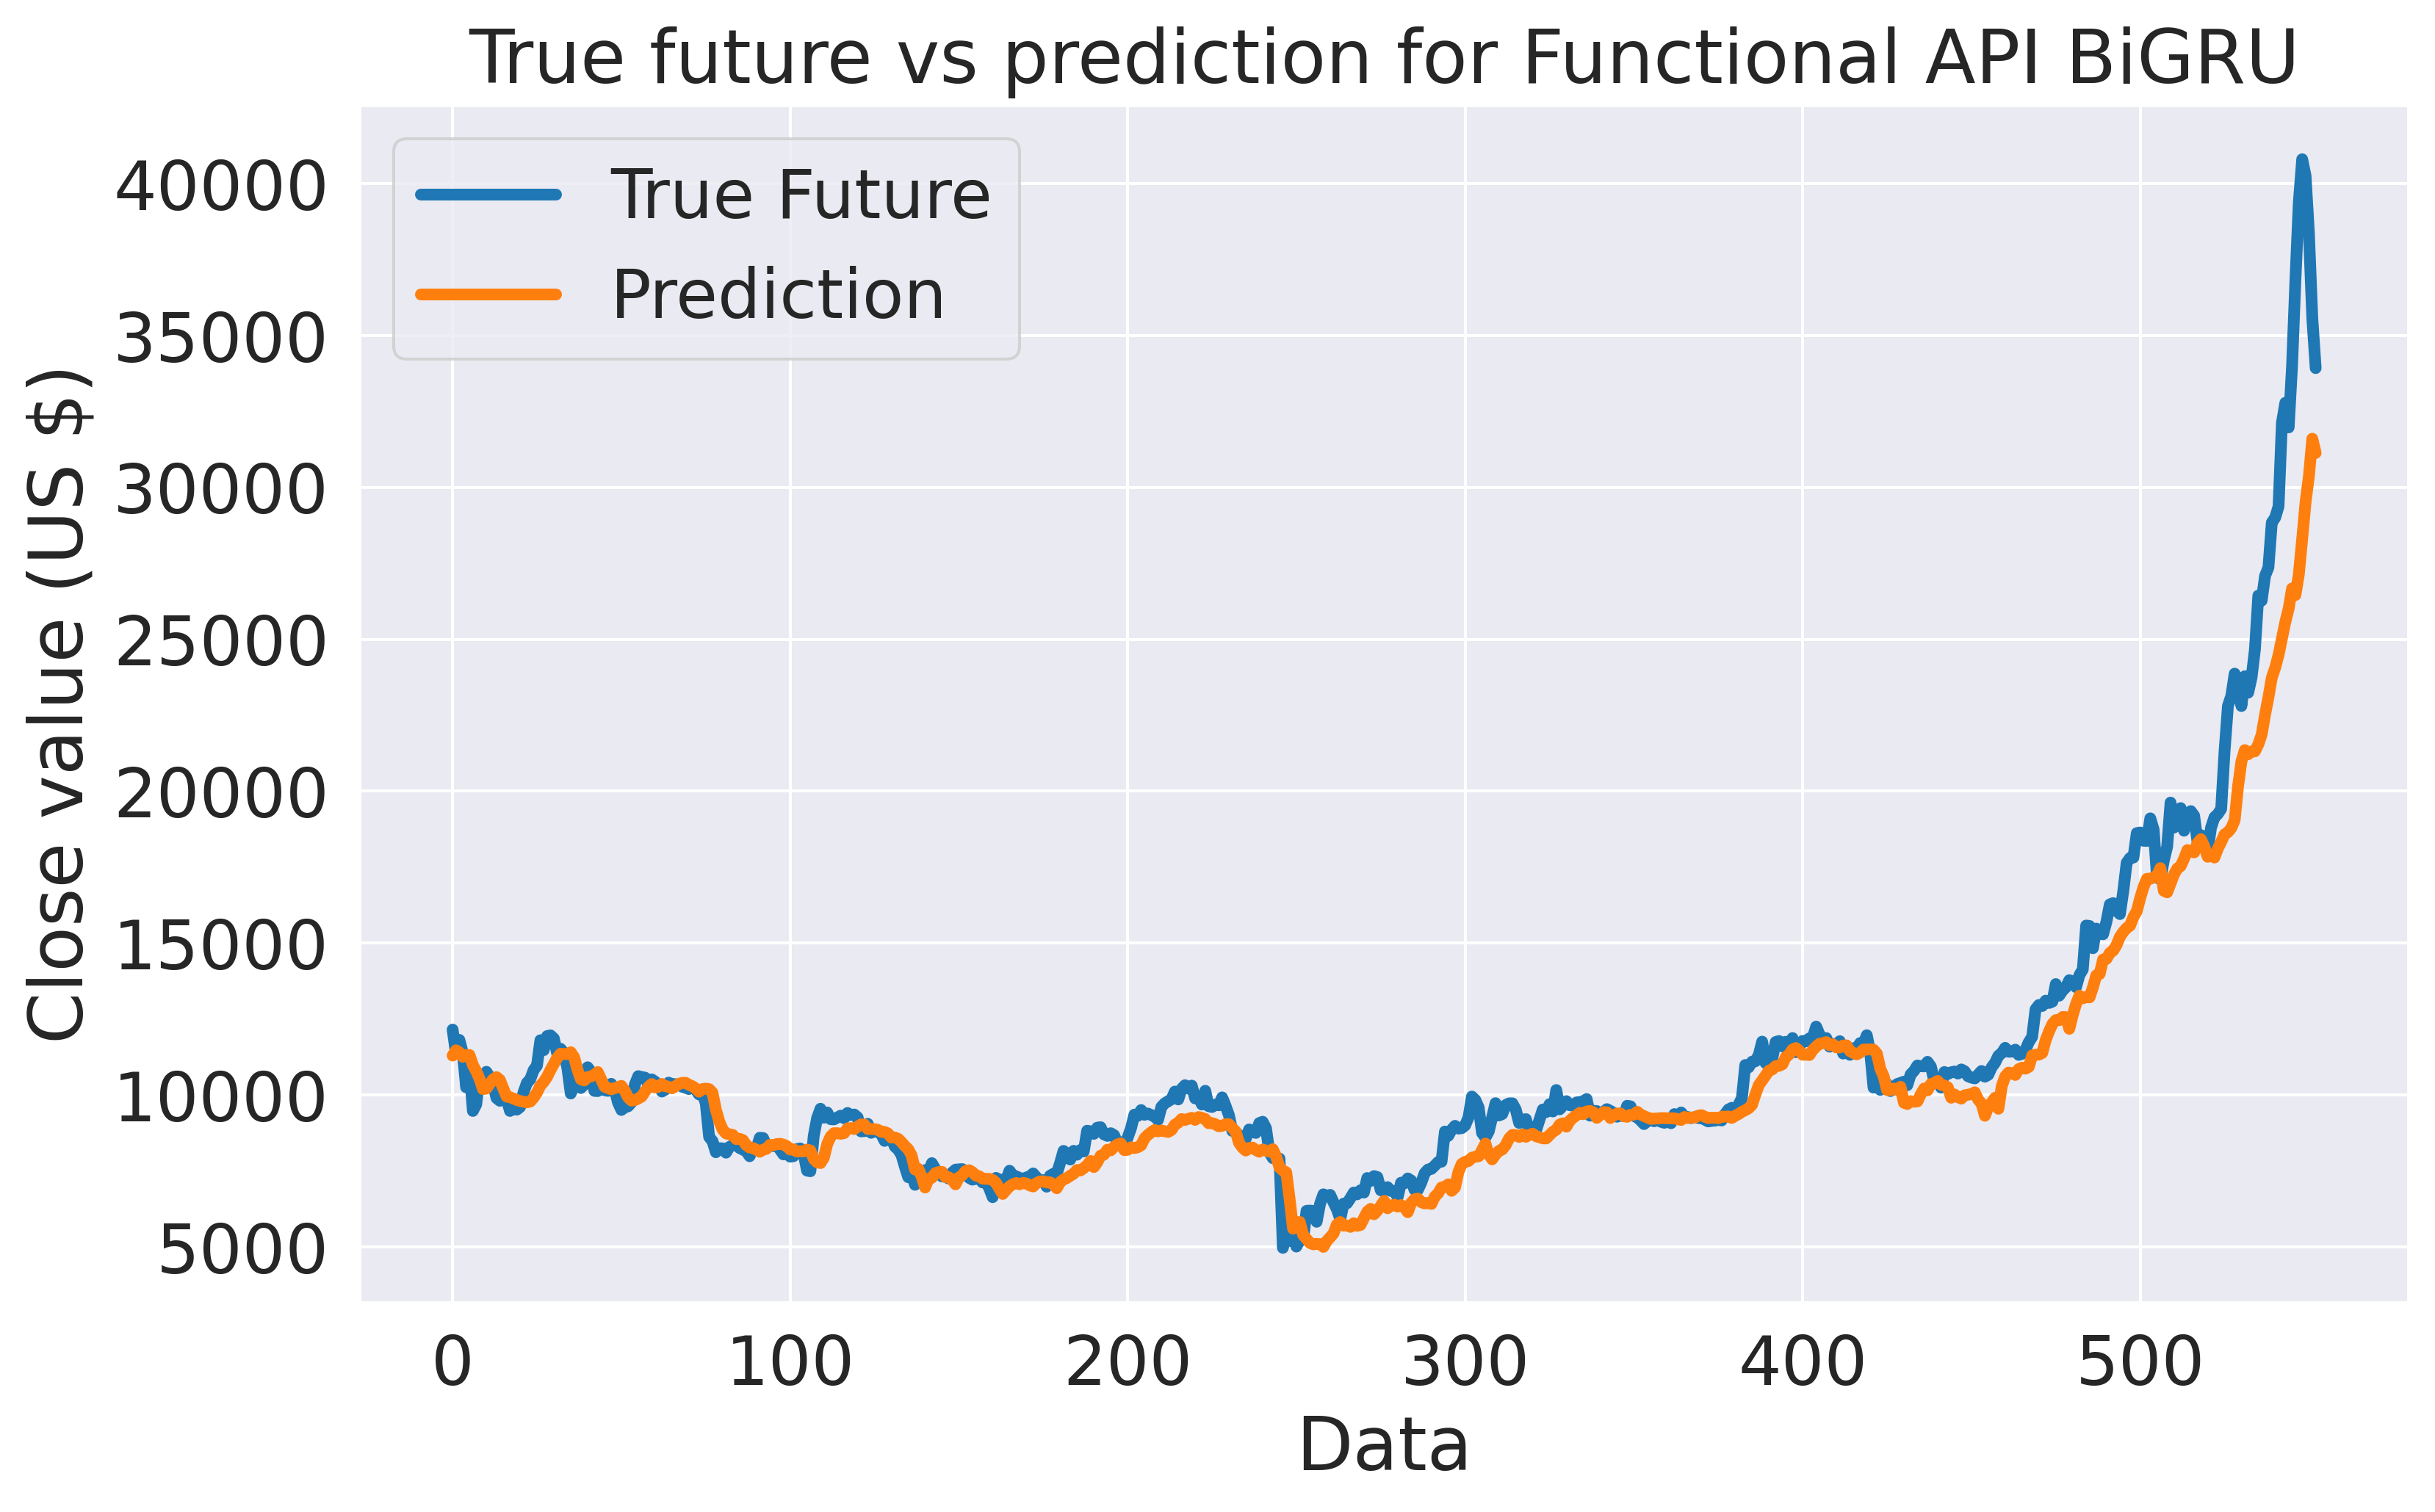

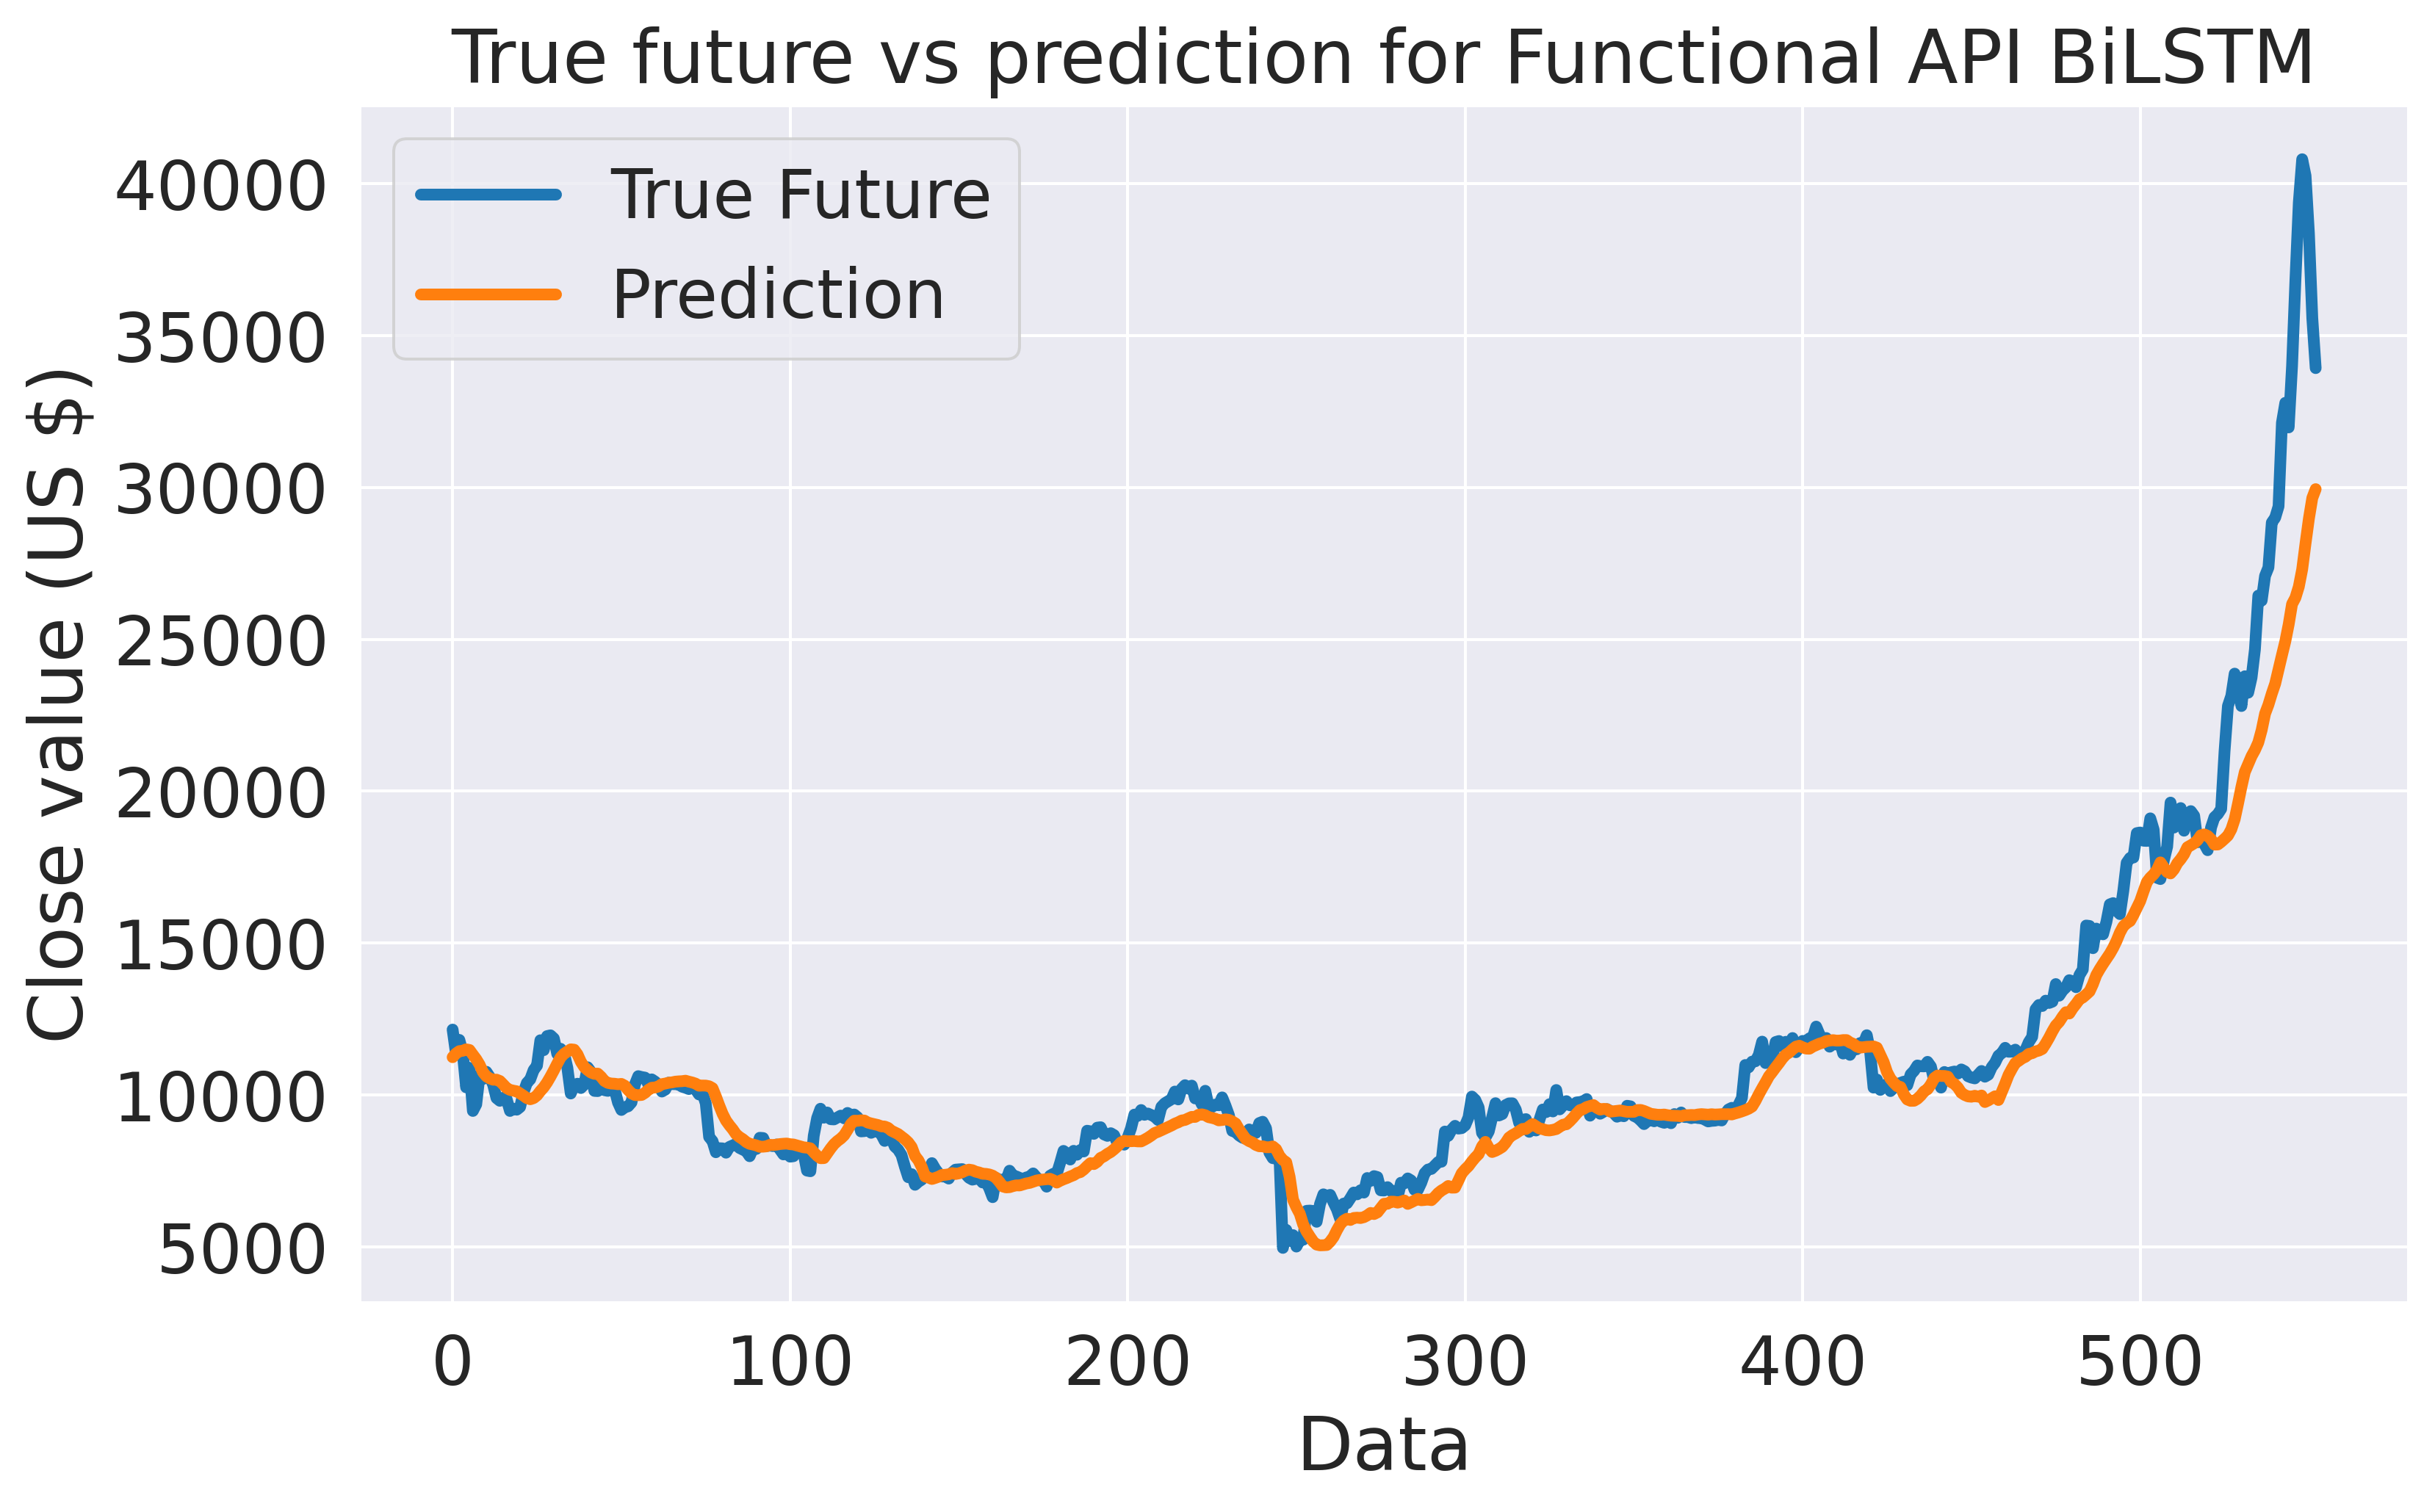

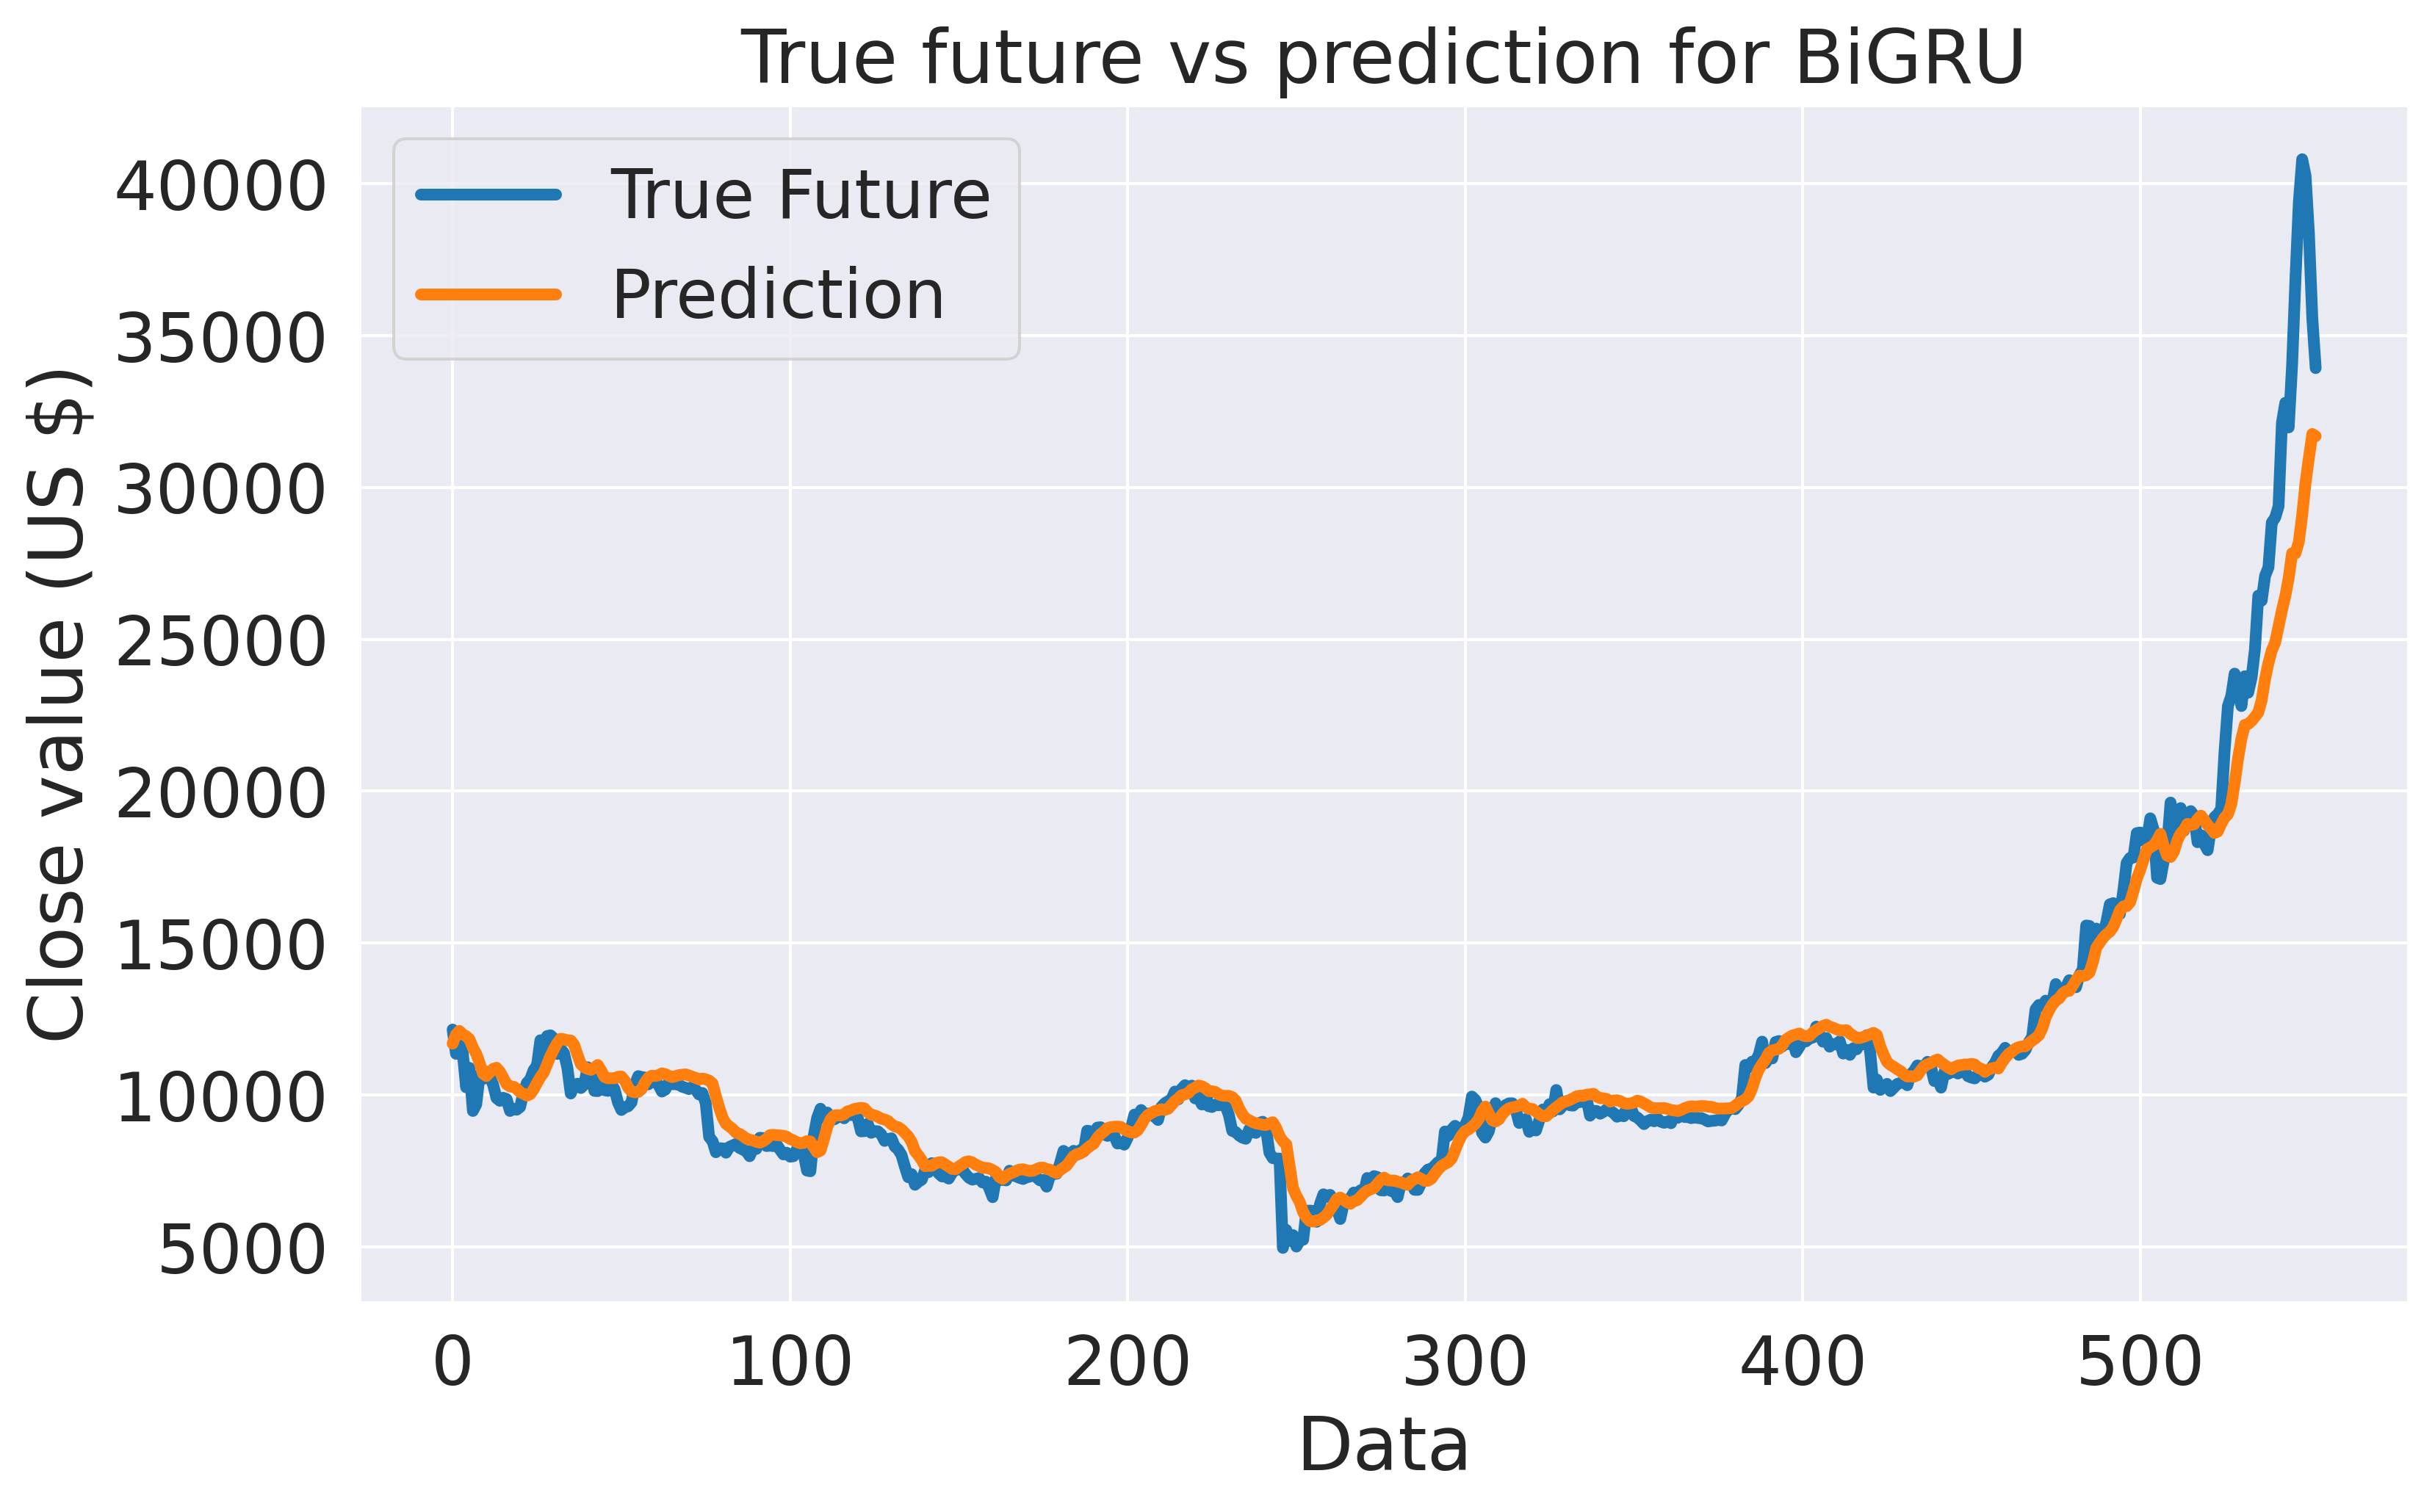

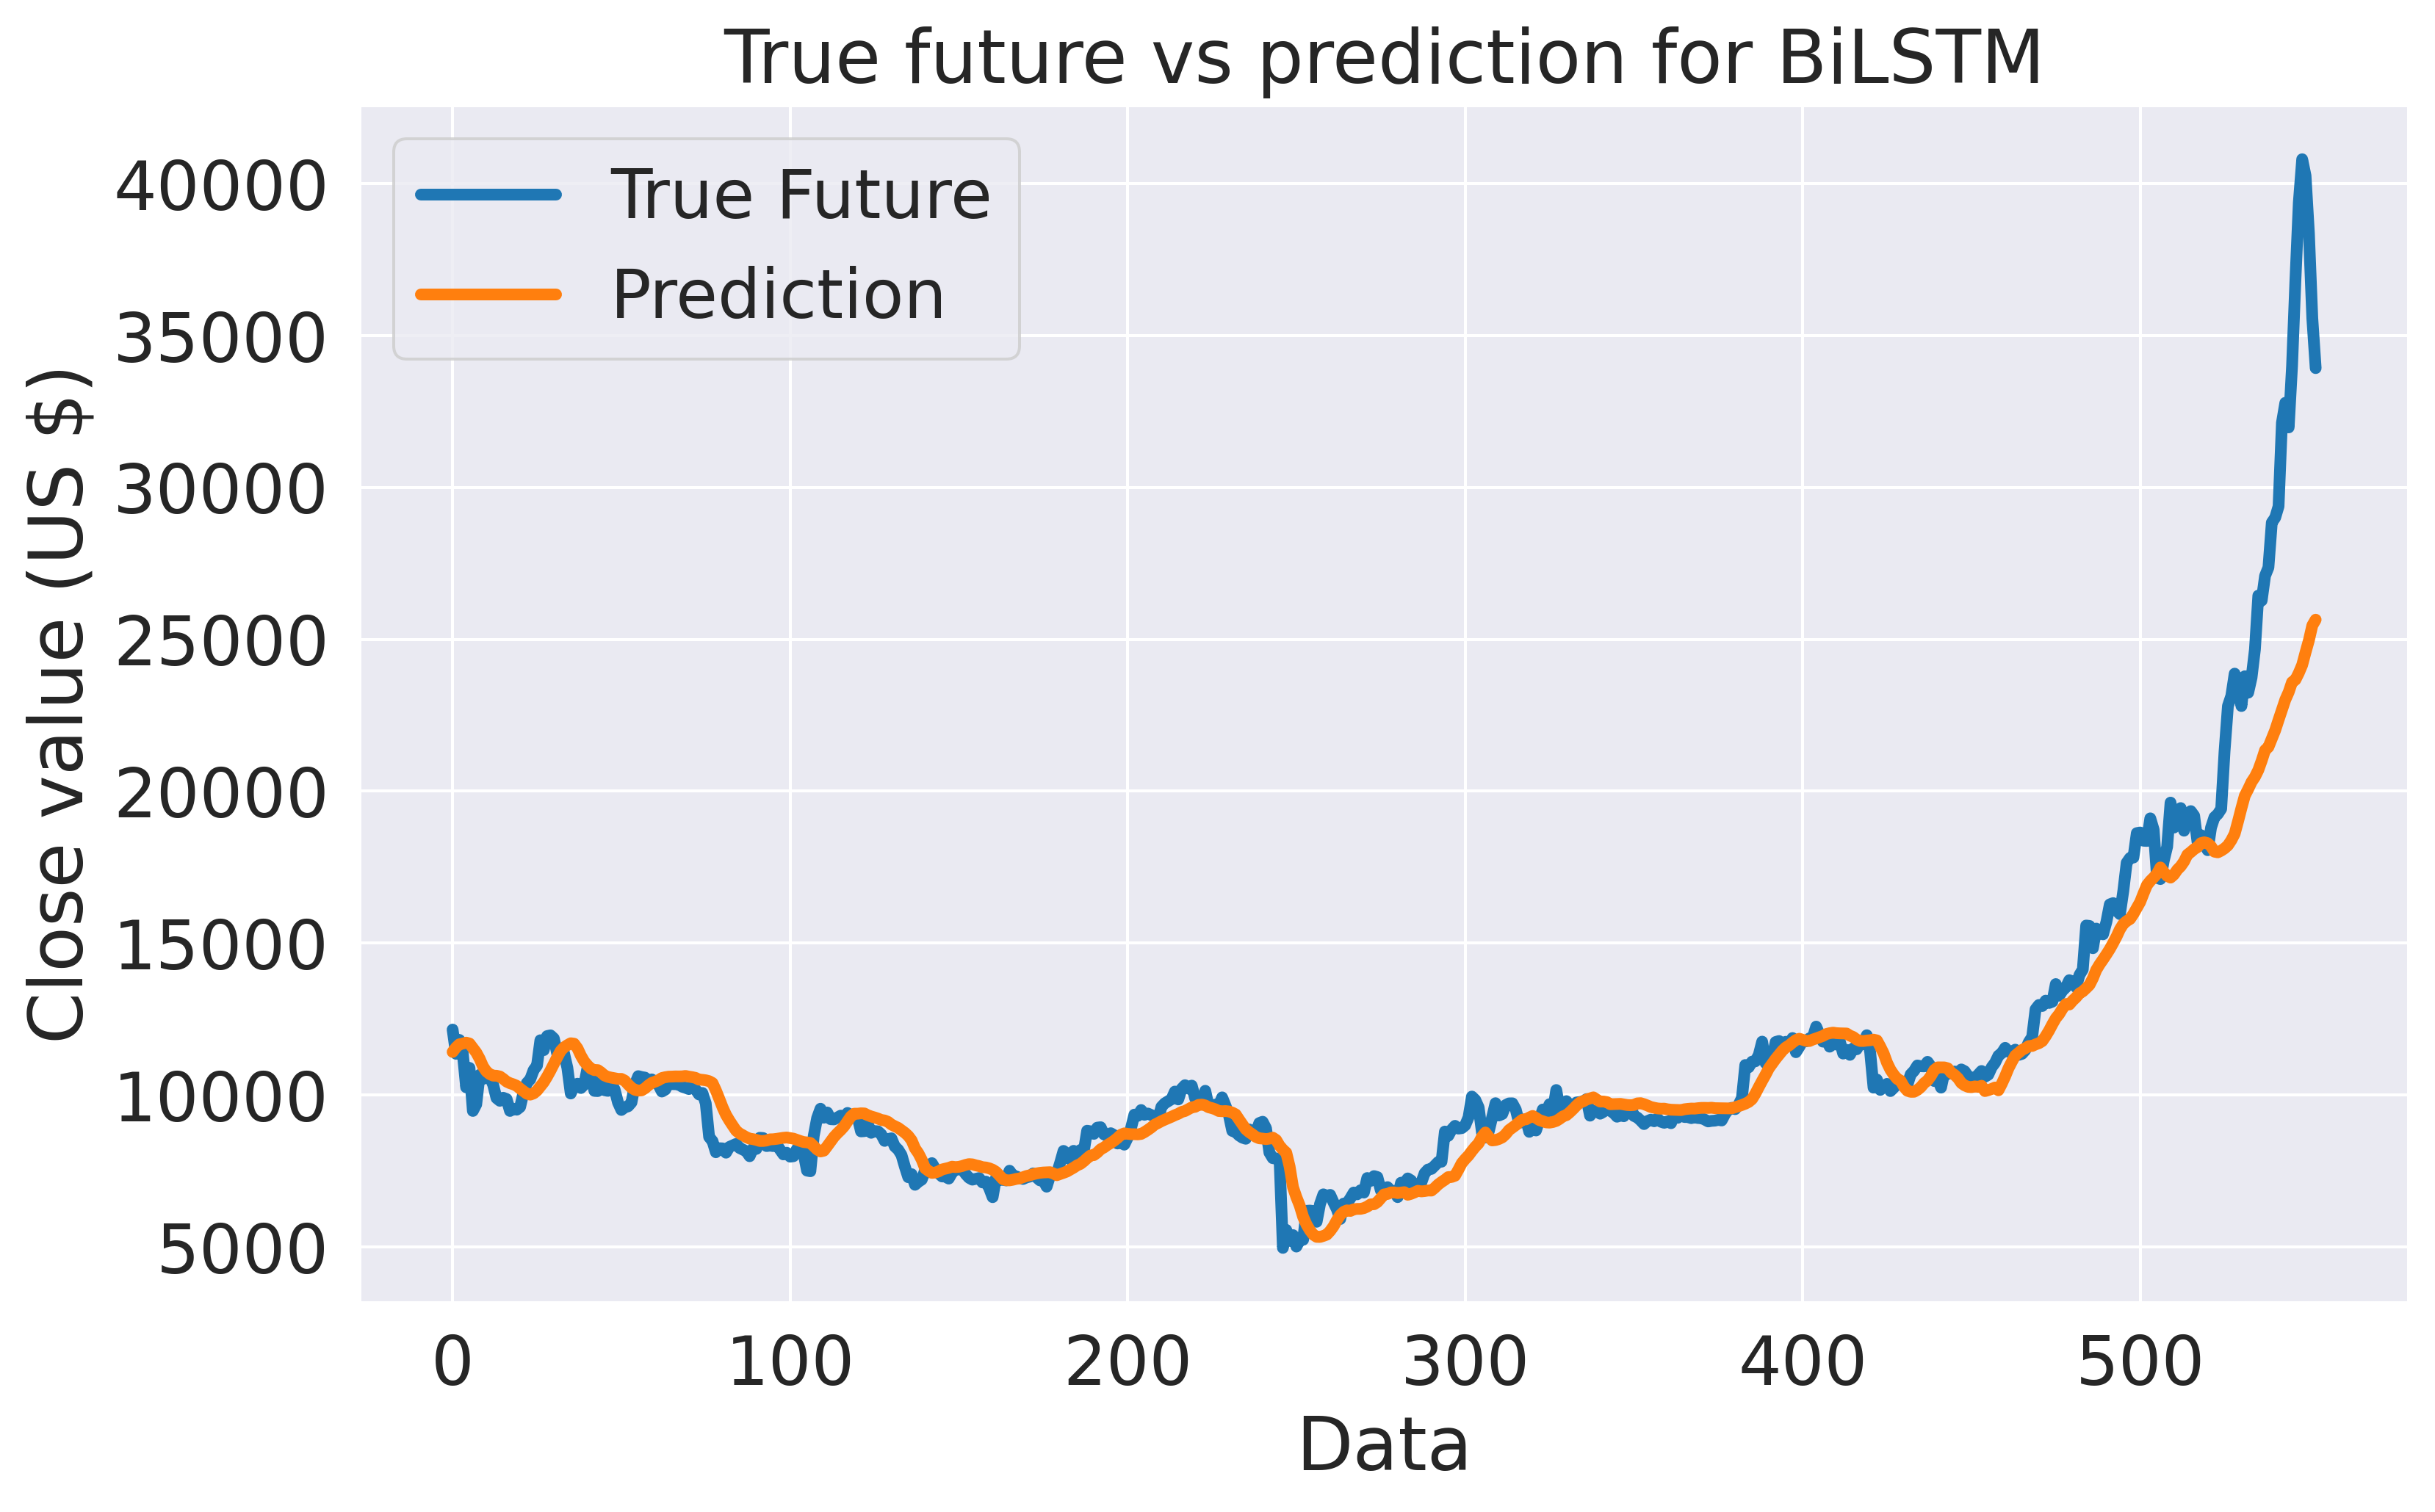

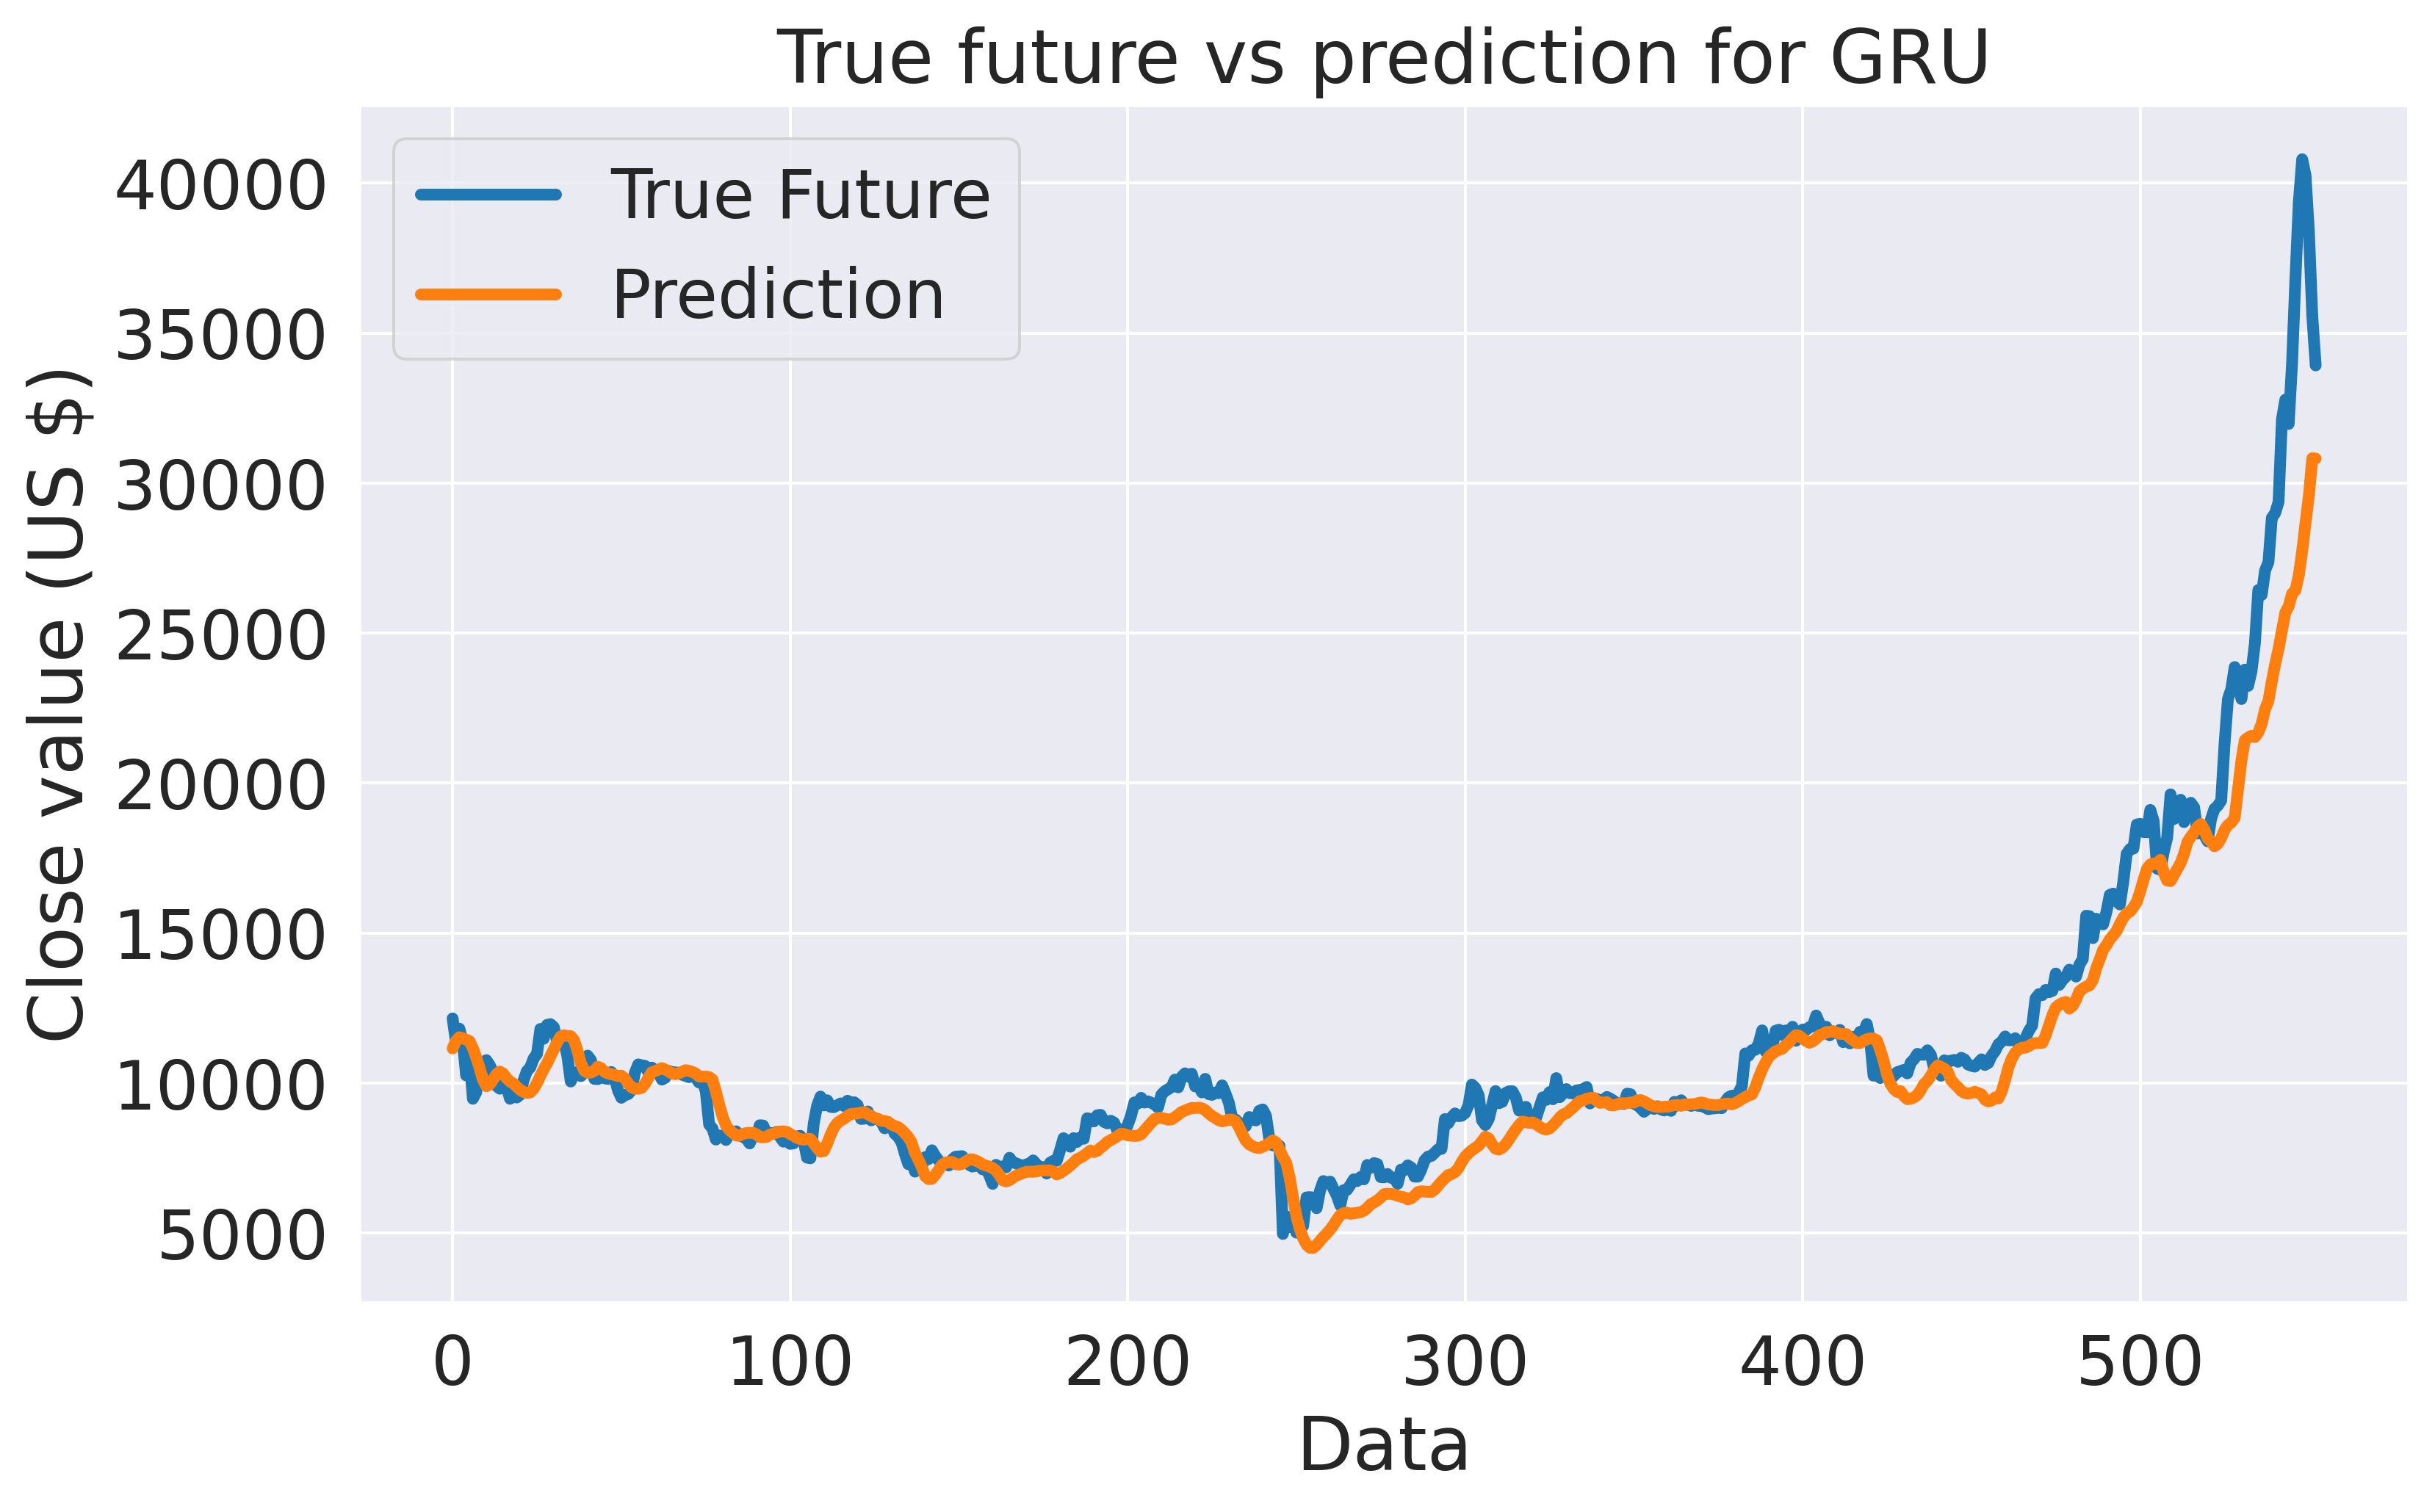

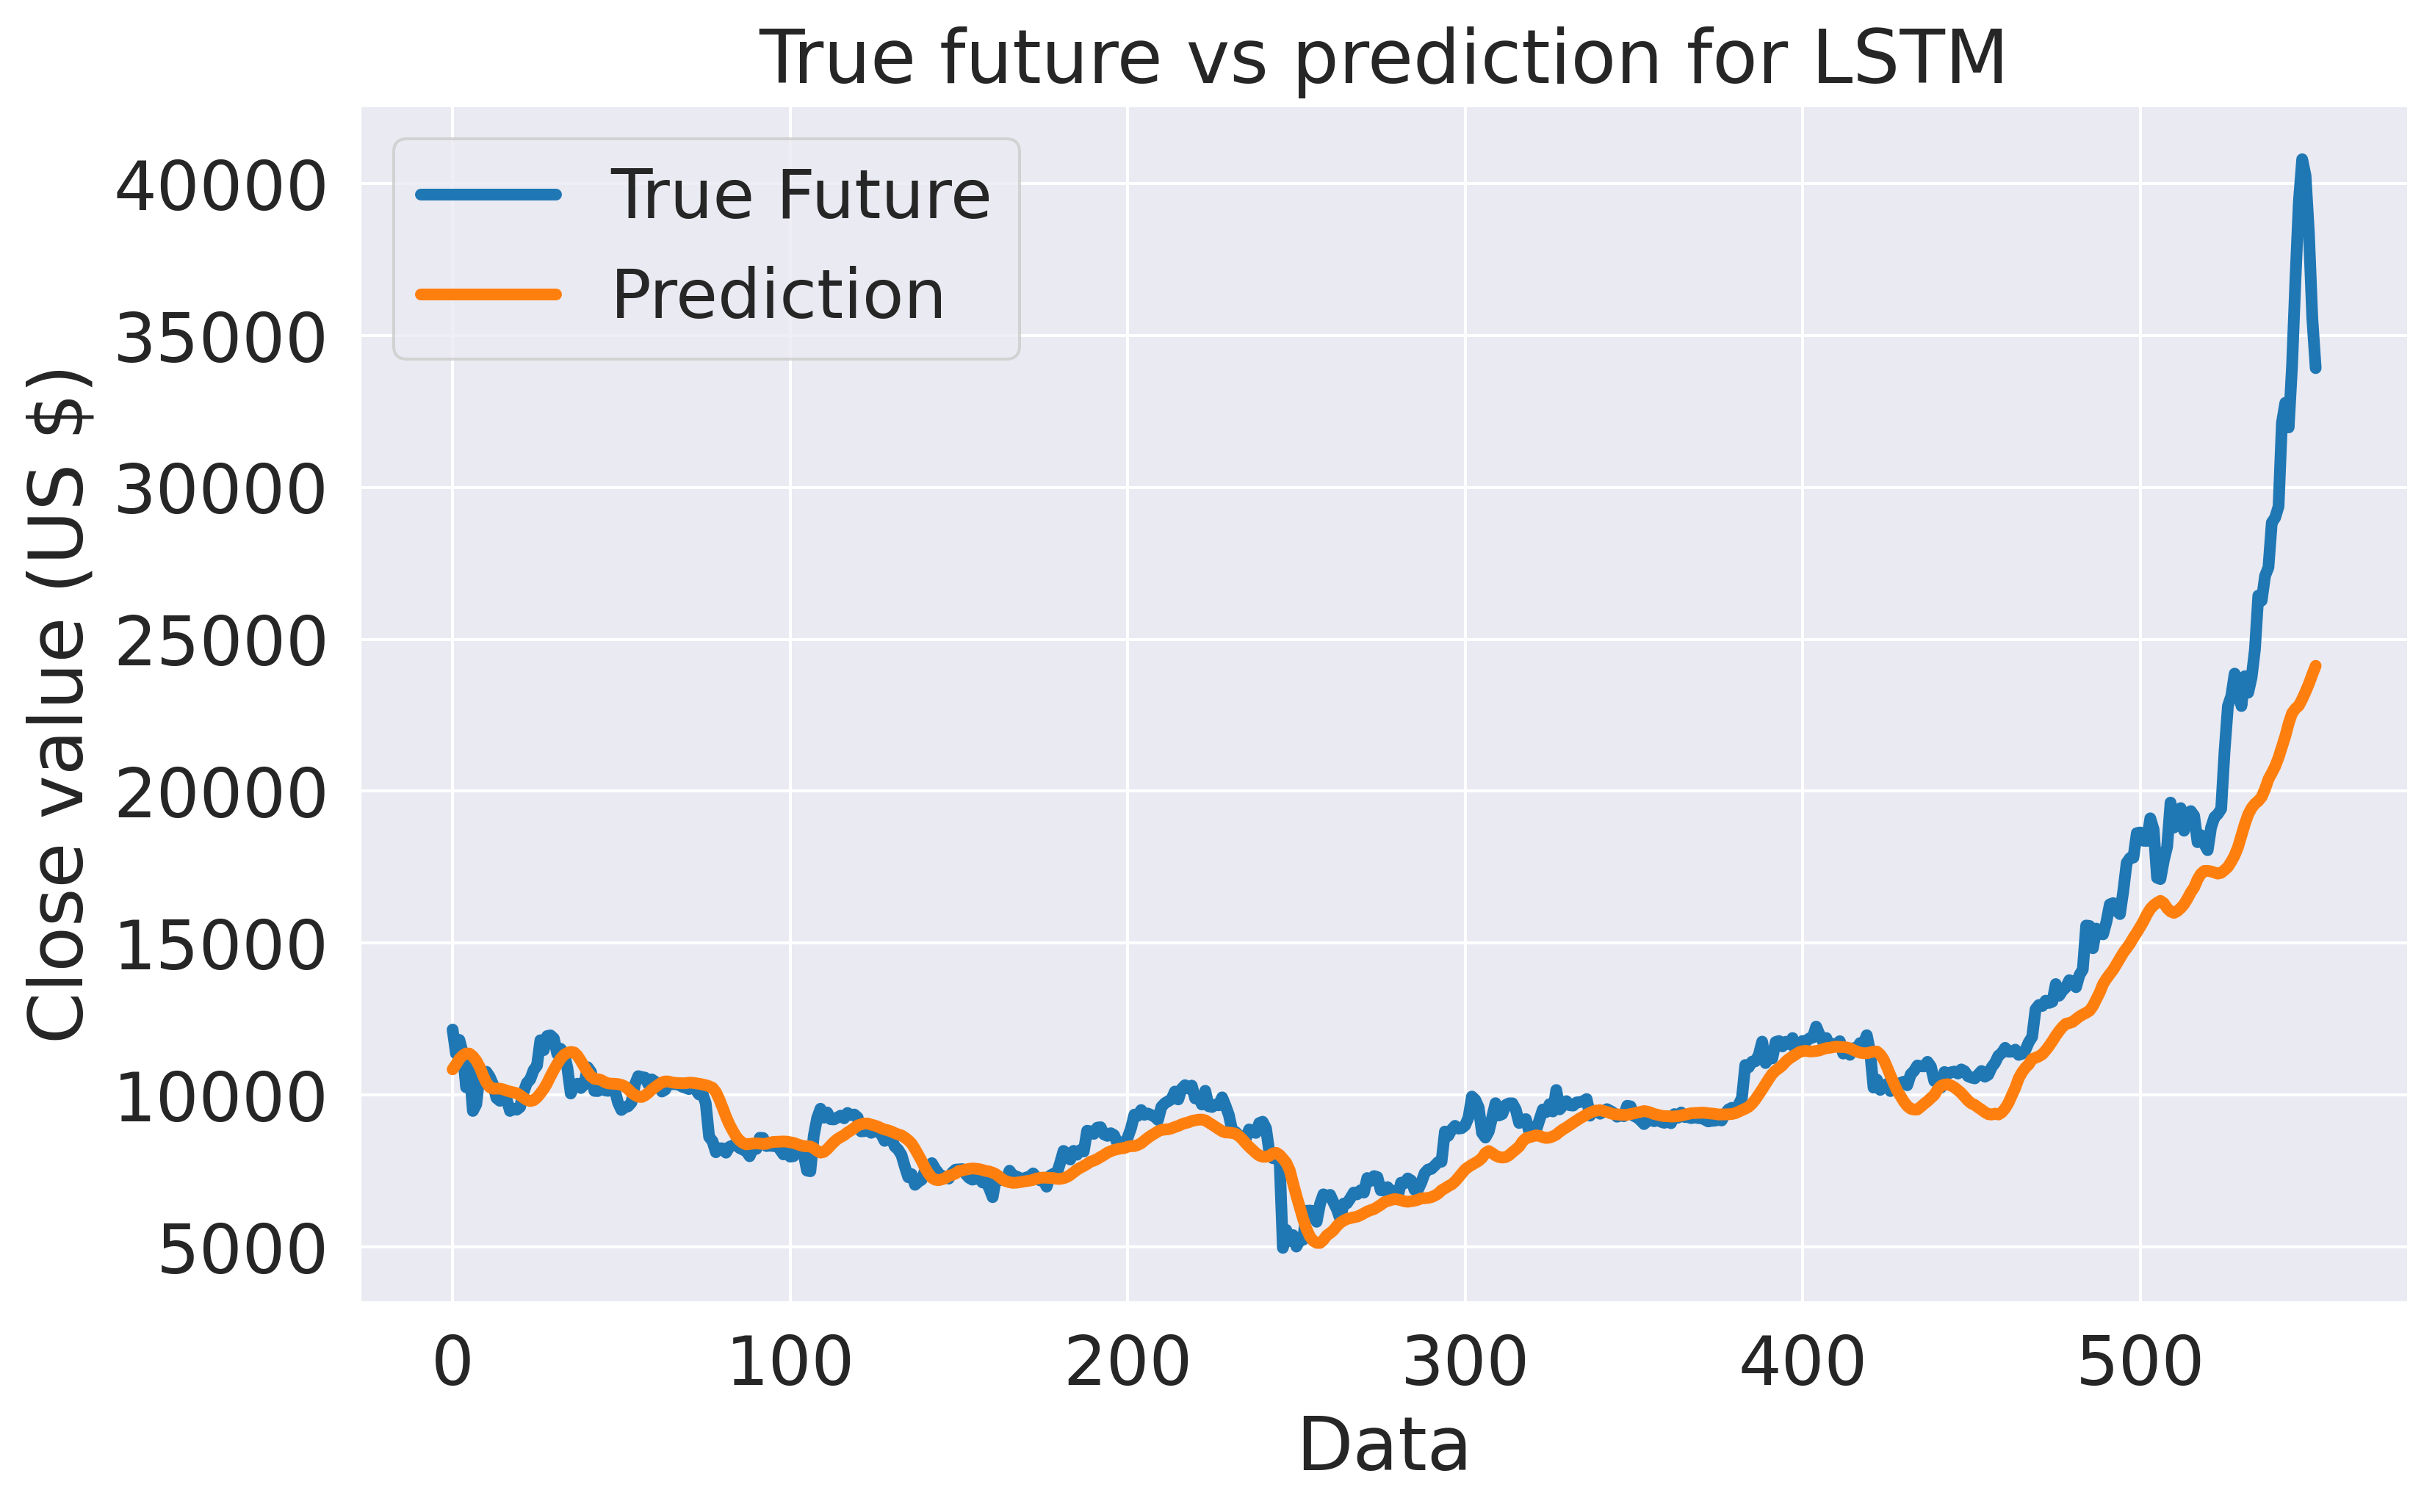

In [ ]:
def plot_future(prediction, model_name, y_test):

    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Data')
    plt.ylabel('Close value (US $)')


plot_future(prediction_bigru_func, 'Functional API BiGRU', y_test)
plot_future(prediction_bilstm_func, 'Functional API BiLSTM', y_test)
plot_future(prediction_bigru, 'BiGRU', y_test)
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)

In [ ]:

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()

    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100


    print(model_name + ':')
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.2f}'.format(mape))

    print('')


evaluate_prediction(prediction_bigru_func, y_test, 'Func Bidirectional GRU')
evaluate_prediction(prediction_bilstm_func, y_test, 'Func Bidirectional LSTM')
evaluate_prediction(prediction_bigru, y_test, 'Bidirectional GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')

"""
corr_matrix = np.corrcoef(y_test, prediction_func_bilstm)
corr = corr_matrix[0,1]
R_sq = corr**2

print(R_sq)
"""

Func Bidirectional GRU:
Mean Absolute Error: 868.73
Root Mean Square Error: 1602.84
Mean Absolute Percentage Error: 6.90

Func Bidirectional LSTM:
Mean Absolute Error: 900.22
Root Mean Square Error: 1704.95
Mean Absolute Percentage Error: 7.16

Bidirectional GRU:
Mean Absolute Error: 678.07
Root Mean Square Error: 1361.69
Mean Absolute Percentage Error: 5.55

Bidirectional LSTM:
Mean Absolute Error: 944.44
Root Mean Square Error: 2087.12
Mean Absolute Percentage Error: 6.99

GRU:
Mean Absolute Error: 932.70
Root Mean Square Error: 1677.66
Mean Absolute Percentage Error: 7.58

LSTM:
Mean Absolute Error: 1171.78
Root Mean Square Error: 2393.81
Mean Absolute Percentage Error: 8.55



'\ncorr_matrix = np.corrcoef(y_test, prediction_func_bilstm)\ncorr = corr_matrix[0,1]\nR_sq = corr**2\n \nprint(R_sq)\n'

In [ ]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.

model_bilstm.save("saved_data/model_bilstm_64")

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("model_bilstm_64")


INFO:tensorflow:Assets written to: saved_data/model_bilstm_64/assets


INFO:tensorflow:Assets written to: saved_data/model_bilstm_64/assets


In [ ]:
!ls saved_data

model_bigru_func.png  model_bilstm_64	     model_bilstm.png  model_lstm.png
model_bigru.png       model_bilstm_func.png  model_gru.png     training.log


In [ ]:
new_model = tf.keras.models.load_model('saved_data/model_bilstm_64')

# Check its architecture
new_model.summary()

In [ ]:
'''
from google.colab.patches import cv2_imshow # for image display

cv2_imshow('saved_data/model_bigru_func.png')
cv2_imshow('saved_data/model_bilstm_func.png')
cv2_imshow('saved_data/model_bigru.png')
cv2_imshow('saved_data/model_bilstm.png')
cv2_imshow('saved_data/model_gru.png')
cv2_imshow('saved_data/model_lstm.png')
'''